<a href="https://colab.research.google.com/github/LeonBusche/AIMA-personal-repo-LeonBusche-/blob/main/week_07_generative_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 3 - Computer Vision

**This week's exercise has 4 tasks, for a total of 10 points. Don't forget to submit your solutions to GitHub!**

In this chapter, we want you to become proficient at the following tasks:
- Building a modern PyTorch segmentation model
- Training a modern model on a real-world segmentation task and achieving passable results

**Note**: This is the last exercise concerning pure computer vision. Starting next week, we will begin with Natural Language Processing, i.e. text data. Therefore, don't worry too much if this exercise feels hard or if you can't complete all of it ;)

#### Chapter 3.5 - Segmentation

In previous tasks, we solved classification problems - we provide some input(s), typically an image, and get out a few numbers, which are the predicted pseudo-probabilities that our input belongs to some class, such as "tumor" or "no tumor". For this exercise, we will explore a new task that is extremely common in medical AI research and in clinical practice. This task is called segmentation. In segmentation, the goal is to go from an input image to one or several segmentations (also called *segmentation maps*) of that image. For the example of LiTS, this means that our input remains the same - a 256x256 image with 1 channel. However, our model outputs and targets are now different - they also have the shape 256x256 pixels, times the number of output classes, in our case 3 (background, liver, liver+tumor). Each 256x256 output is basically a map of which pixels in the original image belong to a certain class with what (pseudo-)probability. The training objective, in its simplest form, is also the same; Cross-Entropy Loss, but per pixel, instead of per-image.

To solve today's tasks, we will need to build ourselves a few new things that look almost the same as things we have already built.

**Task 1 (2 points)**: We will need a new Dataset class. It is the same as usual, except this time, when we return image and target in the getitem method, our target is now also a multi-dimensional tensor of size.

We will return two kinds of targets - class-index targets and one-hot encoded targets. Class-index targets you already know. Every pixel is assigned a class, which can be 0 for background, 1 for liver, and 2 for lesions. The corresponding tensor has the size $H * W$. One-hot encoded targets instead have size $C * H * W$ - each channel is one class (the 0th channel is background, etc.), and the values for each pixel in a channel are 1 if that pixel belongs to that class and 0 if not. We will need both later on - class-index targets because that is the input for the normal CrossEntropyLoss, and one-hot targets because we will use them in this format for our DiceLoss.

Since the "background" class has no segmentations, you will have to improvise them from the existing segmentations for this task.

Your dataset class should return both targets at the end of the \_\_getitem\_\_ method like this: `return image, c_targets, oh_targets`.

In [ ]:
!gdown 1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
!rm -rf ./sample_data/
!unzip -qq Clean_LiTS.zip
!rm ./Clean_LiTS.zip

Downloading...
From (original): https://drive.google.com/uc?id=1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
From (redirected): https://drive.google.com/uc?id=1TItTaso19GFTPdDnynVnqJvHsCm_RGlI&confirm=t&uuid=a0b6a697-ea92-47d7-9ad8-cffdd64c54c8
To: /content/Clean_LiTS.zip
100% 2.56G/2.56G [00:27<00:00, 93.2MB/s]


In [ ]:
import torch
import torchvision.transforms.functional as ttf
import pandas as pd
import PIL
import torch.nn.functional as nnf

class LiTS_Segmentation_Dataset(torch.utils.data.Dataset):

    def __init__(self, csv: str, mode: str):

      self.csv = csv
      self.data = pd.read_csv(self.csv)
      self.mode = mode
      assert mode in ["train", "val", "test"] # has to be train, val, or test data - if not, assert throws an error

    def __len__(self):

      return len(self.data)

    def __getitem__(self, idx: int):

      file = self.data.loc[idx, "filename"]
      liver_mask_file = self.data.loc[idx, "liver_segmentation"]
      lesion_mask_file = self.data.loc[idx, "lesion_segmentation"]
      # Load image
      with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
        f = f.convert("L")
        image = ttf.pil_to_tensor(f)
      with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{liver_mask_file}") as g:
        g = g.convert("L") # unsure if I should do that
        liver_mask = ttf.pil_to_tensor(g).squeeze(0)
      with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{lesion_mask_file}") as h:
        h = h.convert("L") # unsure if I should do that
        lesion_mask = ttf.pil_to_tensor(h).squeeze(0)

      # normalize ( only the image for now )
      image = image.to(dtype = torch.float32)
      image -= torch.min(image)
      image /= torch.max(image)


      #liver_mask = (liver_mask > 127).long()
      #lesion_mask = (lesion_mask > 127).long()

      # Create class-index targets (c_targets)
      # Initialize with background (0)
      c_targets = torch.zeros_like(liver_mask, dtype=torch.long)

      # Set liver pixels to 1
      c_targets[liver_mask > 0] = 1 #  mask values > 0 indicate the class

      # Set lesion pixels to 2 (lesion takes precedence over liver as it's liver+tumor)
      c_targets[lesion_mask > 0] = 2 #  mask values > 0 indicate the class

      # Create one-hot encoded targets (oh_targets)
      # num_classes = 3 (background, liver, lesion)
      oh_targets = nnf.one_hot(c_targets, num_classes=3).permute(2, 0, 1).to(dtype=torch.float32)
      #permute so that the channels come first
      # nnf.one_hot creates a 3dim vector for each pixel with the values 0 = 100, 1 = 010, 2 = 001

      return image, c_targets, oh_targets

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_dataset = LiTS_Segmentation_Dataset(csv ="./Clean_LiTS/train_classes.csv", mode = "train" )
val_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/val_classes.csv", mode = "val")
test_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/test_classes.csv", mode = "test")

batch_size = 32

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    num_workers = 4,
    prefetch_factor = 2,
    shuffle = True,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = 4,
    shuffle = True,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    num_workers = 4,
    shuffle = True,
    drop_last = True
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Task 2 (2 points)**: Plot a few images that contain livers and tumors, as well as their corresponding segmentation maps. Do they look correct? Is there anything special to note?

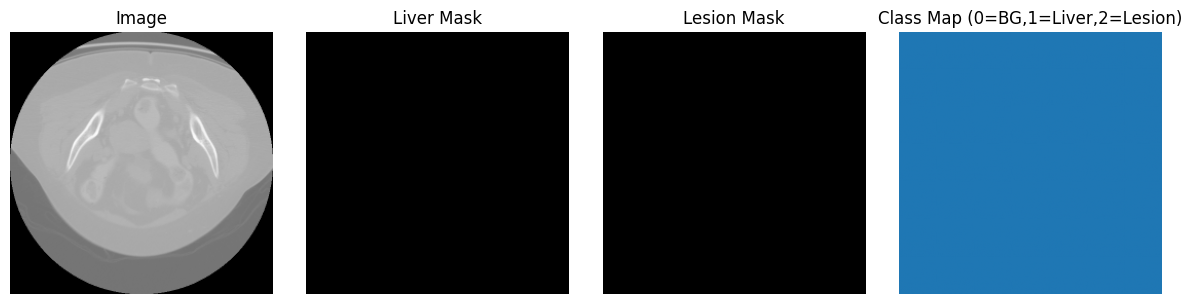

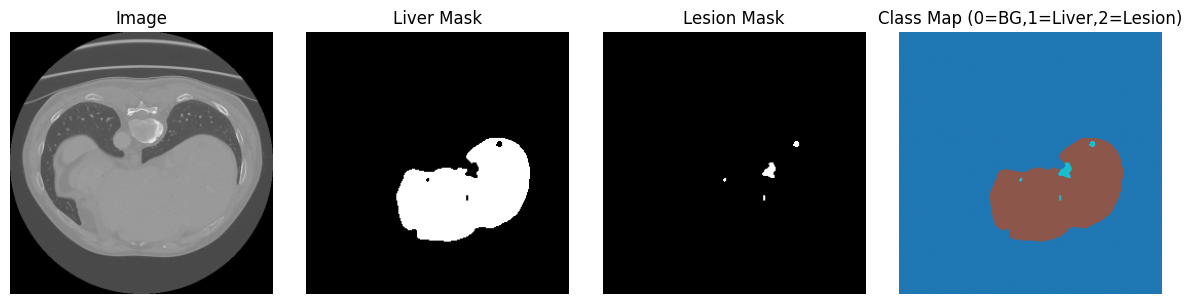

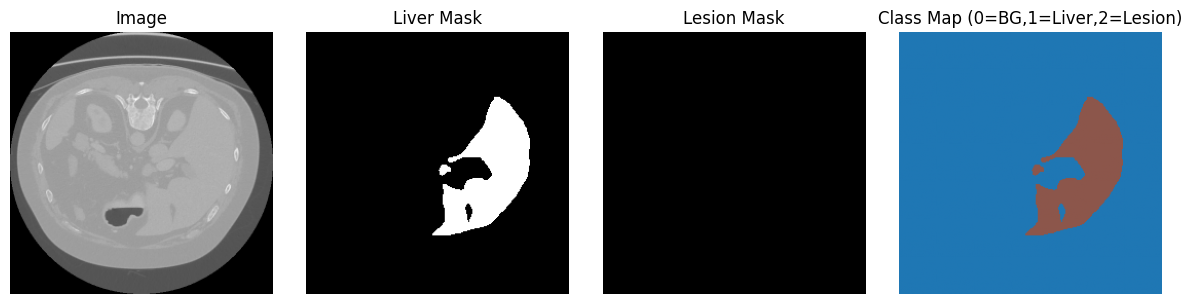

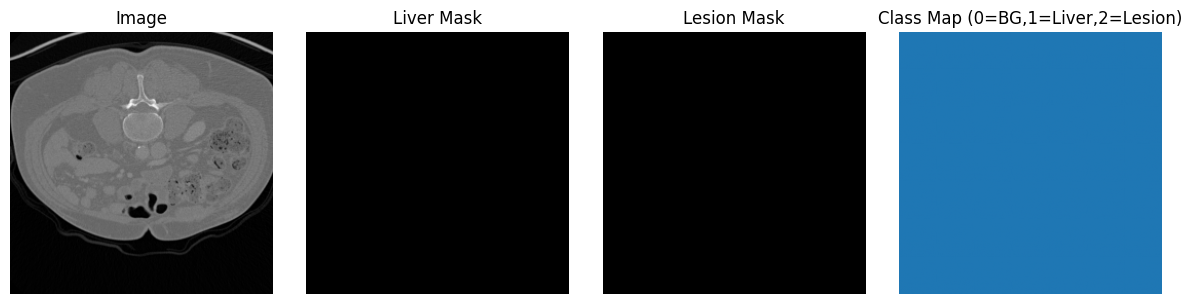

In [ ]:
import matplotlib.pyplot as plt

# Anzahl der Beispiele, die du plotten willst
n = 4

# Ein Batch aus dem DataLoader holen
images, c_targets, oh_targets = next(iter(train_dataloader))

for i in range(n):
    #i += 5
    img = images[i].squeeze(0).cpu()       # (1,H,W) -> (H,W)
    c_map = c_targets[i].cpu()             # (H,W)

    liver = (c_map == 1).float()           # (H,W) 0/1
    lesion = (c_map == 2).float()          # (H,W) 0/1

    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    # Image
    axs[0].imshow(img, cmap="gray")
    axs[0].set_title("Image")

    # Liver Mask
    axs[1].imshow(liver, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Liver Mask")

    # Lesion Mask
    axs[2].imshow(lesion, cmap="gray", vmin=0, vmax=1)
    axs[2].set_title("Lesion Mask")

    # Class Map
    axs[3].imshow(c_map, cmap="tab10", vmin=0, vmax=2)
    axs[3].set_title("Class Map (0=BG,1=Liver,2=Lesion)")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()





# do they look correct?

Keinen plan, ich weiß nicht wie eine tumor aussieht.

ich kann vllt die leber ausmachen, und die masks scheinen genau das auch aufzuzeigen . Tumore sehe ich hier nicht, kann aber auch an den ausgewählten images liegen.

**Task 3 (2 points)**: Next, we need a different loss function. At the bottom, we provide a training/testing loop that already contains cross-entropy loss and a functional segmentation model, plus evaluation. We have learned in the lecture that DICE score, and by extension a DICE-based loss, can be useful for imbalanced classes. We have also discovered that LiTS 2017 contains a class imbalance - slices with tumors are much more rare than slices with livers. Hence, we will make our own DICE loss.

The formula for the DICE loss is computed as follows: $1 - \frac{2 * (|X \land Y|)+\epsilon}{|X|+|Y|+\epsilon}$, where $X$ is the prediction and $Y$ the target.

The DICE Loss class you create should fulfill the following criteria:
- It subclasses torch.nn.module.
- It is a class that implements an \_\_init\_\_ function.
- The loss also implements a \_\_forward\_\_ function that accepts as inputs a prediction tensor and a target tensor, both of shape B x 3 x 256 x 256 - 3 channels because we will segment background, liver, and liver+tumor again. The output is the computed loss.
- You may add class weighting to offset the class imbalance.

Your total loss should be `total_loss = ce_loss + dice_loss`, and your backward pass should be `total_loss.backward()`.
Run the training for a few epochs, once with and once without DICE loss included as part of the overall loss. In your experiment, which version worked better? Hä? what are we supposed to train?

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as nnf

def compute_dice_score(prediction: torch.Tensor, target: torch.Tensor):

    """
    Computes the dice score for one class.
    """

    prediction = prediction.to(dtype = torch.bool)
    target = target.to(dtype = torch.bool)

    intersection = torch.sum(prediction * target)   # TP
    p_cardinality = torch.sum(prediction)           # TP+FP
    t_cardinality = torch.sum(target)               # TP+FN
    cardinality = p_cardinality + t_cardinality
    eps = 1e-8

    if cardinality != 0:
        dice = (2 * intersection + eps) / (cardinality + eps) # 2*TP / (2*TP+FP+FN + eps)
    else:
        dice = None

    return dice


class BinaryDiceLoss(nn.Module):
    """
    Binary Dice Loss. Targets must be one-hot encoded.
    Needed to make a full DICE loss, this computes dice loss for one channel.
    """

    def __init__(self):
        super().__init__()

    def forward(self, prediction: torch.Tensor, target: torch.Tensor):
        # prediction and target: (B,H,W) binary float tensors
        eps = 1e-8
        intersection = torch.sum(prediction * target, dim=(1,2))
        cardinality = torch.sum(prediction + target, dim=(1,2))
        loss = 1 - (2 * intersection + eps) / (cardinality + eps)
        return loss.mean()

class DiceLoss(nn.Module):
    """
    Dice Loss. Targets must be one-hot encoded.
    """

    def __init__(self, num_classes: int):
        super().__init__()
        self.num_classes = num_classes
        self.bce = nn.CrossEntropyLoss()  # optional if you want class weighting

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor):
        """
        predictions: (B,C,H,W) raw logits
        targets: (B,C,H,W) one-hot float
        """
        # Softmax über Klassen
        probs = F.softmax(predictions, dim=1)

        dice_loss = 0
        for c in range(self.num_classes):
            dice_loss += BinaryDiceLoss()(probs[:,c], targets[:,c])

        dice_loss /= self.num_classes
        return dice_loss


**Task 4 (4 points)**: Finally, we want to make our own model that can handle segmentations. For this course, we will build ourselves a U-Net. The original paper can be found here: https://arxiv.org/pdf/1505.04597.

The input dimensions for the network will be the usual B x 1 x 256 x 256. The output dimensions should be B x 3 x 256 x 256. We have three output channels because we will still predict classes 0 (background), 1 (liver) and 2 (liver tumor) - this time, however, we predict the classes on a per-pixel basis.

Since our input images have vastly smaller dimensions compared to those used in the original UNet-Paper, we will opt for a different scale of UNet. The general design remains the same as in the paper, except:

- We will only downsample 3 times by a factor of 2, using MaxPool (for a minimum resolution 32x32).
- Our 3x3 Convolutions will have Padding. Consequently, there will be no cropping during skip connections
- We will only have 3 skip connections.
- We will go for fewer maximum channels (as we have only 3 downsampling steps, we will have 64, 128, 256, and 512 channels).
- Our final output will be 3 channels wide, not 2 (we predict background, liver, and liver tumors).

Note that training a segmentation models takes a little while - we do not award points for results here, because it would mean that you would have to wait a long time to see whether your changes helped performance. All we want to see is that your model learns anything useful at all. As a rough guideline, you will probably start seeing ok liver segmentations after 1 epoch, and good liver and ok lesion segmentations after 2 or 3 epochs.

If everything works correctly, you can copy the previous training loop and should get some good results. Don't forget to look at some of your predictions! Are they reasonable? Empty? Weird? Can you discover some kind of systemic issues with your predictions?

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Einfacher Double Convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# U-Net Modell
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Output Layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Bottleneck
        b = self.bottleneck(self.pool3(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return out


In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

model = UNet() # Your model class goes here
model = model.to(device)

dice_loss = DiceLoss(num_classes = 3) # Your dice loss class goes here
ce_loss = nn.CrossEntropyLoss(
    weight = torch.tensor([1.0, 5.0, 20.0]).to(device = device),
    reduction = "mean",
    #ignore_index = 0
    )

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
# If your model and loss work, this should at least execute successfully.
# If you only wish to test your model, just comment out the dice_loss component everywhere.

from tqdm.auto import tqdm

num_epochs = 5
avg_liver_dice = 0
avg_lesion_dice = 0
dice_weight = 1
ce_weight = 1

for epoch in range(num_epochs):

    for step, (data, c_targets, oh_targets) in enumerate(train_dataloader):

        optimizer.zero_grad()
        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
        predictions = model(data)

        loss_1 = dice_loss(predictions, oh_targets)
        loss_2 = ce_loss(predictions, c_targets)
        total_loss = loss_1 * dice_weight + loss_2 * ce_weight # We could weight contributions from the different loss components here, although 1-to-1 should do just fine

        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]\t Step [{step+1}/{len(train_dataloader.dataset)//batch_size}]\t Loss: {total_loss.item():.4f}")

        total_loss.backward()
        optimizer.step()

        # Validate once after every epoch
        model.eval()

        # Don't track gradients for validation
        with torch.no_grad():

            losses = []
            background_dices = []
            background_counts = []
            liver_dices = []
            liver_counts = []
            lesion_dices = []
            lesion_counts = []
            batch_sizes = []

            for val_step, (data, c_targets, oh_targets) in enumerate(tqdm(val_dataloader)):

                data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
                predictions = model(data)
                # Choose the likeliest prediction via argmax, then convert to one-hot, and put the new axis in front again
                p_arg = nnf.one_hot(torch.argmax(predictions, dim = 1), num_classes = 3).moveaxis(-1, 1)

                # loss
                loss_1 = dice_loss(predictions, oh_targets)
                loss_2 = ce_loss(predictions, c_targets)
                total_loss = loss_1 * dice_weight + loss_2 * ce_weight # We could weight contributions from the different loss components here, although 1-to-1 should do just fine

                losses.append(total_loss.item())
                batch_sizes.append(data.size()[0])

                background_seg = oh_targets[:, 0, :, :]
                liver_seg = oh_targets[:, 1, :, :]
                lesion_seg = oh_targets[:, 2, :, :]

                background_dice = compute_dice_score(p_arg[:,0,:,:], background_seg)
                background_counts.append(data.size()[0])
                background_dices.append(background_dice)

                if liver_seg.sum() != 0.0:
                    liver_dice = compute_dice_score(p_arg[:,1,:,:], liver_seg)
                    liver_counts.append(data.size()[0])
                    liver_dices.append(liver_dice)

                if lesion_seg.sum() != 0.0:
                    lesion_dice = compute_dice_score(p_arg[:,2,:,:], lesion_seg)
                    lesion_counts.append(data.size()[0])
                    lesion_dices.append(lesion_dice)

            avg_background_dice = sum([dice * size for dice, size in zip(background_dices, background_counts)])/sum(background_counts)
            avg_liver_dice = sum([dice * size for dice, size in zip(liver_dices, liver_counts)])/sum(liver_counts)
            avg_lesion_dice = sum([dice * size for dice, size in zip(lesion_dices, lesion_counts)])/sum(lesion_counts)

            avg_loss = sum([l * bs for l, bs in zip(losses, background_counts)]) / sum(background_counts)
            print(f"Epoch: {epoch+1},\t Validation Loss: {avg_loss:.4f},\t Liver Dice Score: {avg_liver_dice:.4f}, \t Lesion Dice Score: {avg_lesion_dice:.4f}")

            # After we are done validating, let's not forget to go back to storing gradients.
            model.train()

Epoch [1/5]	 Step [1/1108]	 Loss: 2.1556


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9520,	 Liver Dice Score: 0.0000, 	 Lesion Dice Score: 0.0038


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9603,	 Liver Dice Score: 0.0000, 	 Lesion Dice Score: 0.0039


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9698,	 Liver Dice Score: 0.0000, 	 Lesion Dice Score: 0.0039


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9791,	 Liver Dice Score: 0.0000, 	 Lesion Dice Score: 0.0039


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9887,	 Liver Dice Score: 0.0000, 	 Lesion Dice Score: 0.0040


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9982,	 Liver Dice Score: 0.0001, 	 Lesion Dice Score: 0.0040


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0075,	 Liver Dice Score: 0.0577, 	 Lesion Dice Score: 0.0008


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch: 1,	 Validation Loss: 2.0162,	 Liver Dice Score: 0.0395, 	 Lesion Dice Score: 0.0001


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():   
   ^ ^ ^ ^  ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^   
    File "/usr/lib/

Epoch: 1,	 Validation Loss: 2.0245,	 Liver Dice Score: 0.0360, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0324,	 Liver Dice Score: 0.0353, 	 Lesion Dice Score: 0.0000
Epoch [1/5]	 Step [11/1108]	 Loss: 1.8583


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0387,	 Liver Dice Score: 0.0352, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0443,	 Liver Dice Score: 0.0349, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0485,	 Liver Dice Score: 0.0351, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0513,	 Liver Dice Score: 0.0350, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch: 1,	 Validation Loss: 2.0520,	 Liver Dice Score: 0.0350, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():
^ ^ ^^^  ^ ^  ^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ 
   File "/usr/lib/pyt

Epoch: 1,	 Validation Loss: 2.0486,	 Liver Dice Score: 0.0352, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0381,	 Liver Dice Score: 0.0354, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 2.0212,	 Liver Dice Score: 0.0360, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9996,	 Liver Dice Score: 0.0409, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9710,	 Liver Dice Score: 0.0442, 	 Lesion Dice Score: 0.0000
Epoch [1/5]	 Step [21/1108]	 Loss: 1.6276


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9366,	 Liver Dice Score: 0.0472, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.9046,	 Liver Dice Score: 0.0339, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

Epoch: 1,	 Validation Loss: 1.8828,	 Liver Dice Score: 0.0459, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.8696,	 Liver Dice Score: 0.0509, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.8500,	 Liver Dice Score: 0.0499, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.8141,	 Liver Dice Score: 0.0013, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.8265,	 Liver Dice Score: 0.0213, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.7807,	 Liver Dice Score: 0.0012, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch: 1,	 Validation Loss: 1.7252,	 Liver Dice Score: 0.0004, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b38fbf01ee0>   
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^^if w.is_alive():
^ ^^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^   ^^  ^ ^ ^ ^ ^  ^^^^^^^
^  File "

Epoch: 1,	 Validation Loss: 1.6852,	 Liver Dice Score: 0.0002, 	 Lesion Dice Score: 0.0000
Epoch [1/5]	 Step [31/1108]	 Loss: 1.5069


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.6523,	 Liver Dice Score: 0.0001, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Validation Loss: 1.6261,	 Liver Dice Score: 0.0001, 	 Lesion Dice Score: 0.0000


  0%|          | 0/94 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Test once
model.eval()

# Don't track gradients for testing
with torch.no_grad():

    losses = []
    background_dices = []
    background_counts = []
    liver_dices = []
    liver_counts = []
    lesion_dices = []
    lesion_counts = []
    batch_sizes = []

    for test_step, (data, c_targets, oh_targets) in enumerate(tqdm(test_dataloader)):

        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
        predictions = model(data)
        # Choose the likeliest prediction via argmax, then convert to one-hot, and put the new axis in front again
        p_arg = nnf.one_hot(torch.argmax(predictions, dim = 1), num_classes = 3).moveaxis(-1, 1)

        # loss
        loss_1 = dice_loss(predictions, oh_targets)
        loss_2 = ce_loss(predictions, c_targets)
        total_loss = loss_1 * dice_weight + loss_2 * ce_weight # We could weight contributions from the different loss components here, although 1-to-1 should do just fine

        losses.append(total_loss.item())
        batch_sizes.append(data.size()[0])

        background_seg = oh_targets[:, 0, :, :]
        liver_seg = oh_targets[:, 1, :, :]
        lesion_seg = oh_targets[:, 2, :, :]

        background_dice = compute_dice_score(p_arg[:,0,:,:], background_seg)
        background_counts.append(data.size()[0])
        background_dices.append(background_dice)

        if liver_seg.sum() != 0.0:
            liver_dice = compute_dice_score(p_arg[:,1,:,:], liver_seg)
            liver_counts.append(data.size()[0])
            liver_dices.append(liver_dice)

        if lesion_seg.sum() != 0.0:
            lesion_dice = compute_dice_score(p_arg[:,2,:,:], lesion_seg)
            lesion_counts.append(data.size()[0])
            lesion_dices.append(lesion_dice)

    avg_background_dice = sum([dice * size for dice, size in zip(background_dices, background_counts)])/sum(background_counts)
    avg_liver_dice = sum([dice * size for dice, size in zip(liver_dices, liver_counts)])/sum(liver_counts)
    avg_lesion_dice = sum([dice * size for dice, size in zip(lesion_dices, lesion_counts)])/sum(lesion_counts)

    avg_loss = sum([l * bs for l, bs in zip(losses, background_counts)]) / sum(background_counts)
    print(f"Epoch: {epoch+1},\t Test Loss: {avg_loss:.4f},\t Liver Dice Score: {avg_liver_dice:.4f}, \t Lesion Dice Score: {avg_lesion_dice:.4f}")

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1,	 Test Loss: 1.6208,	 Liver Dice Score: 0.0003, 	 Lesion Dice Score: 0.0000


In [ ]:
import torch

def train_loop_unet_ce(train_dataloader, val_dataloader, device, num_epochs=2):

    # Model
    model = UNet(in_channels=1, out_channels=3).to(device)

    # Loss + Optimizer
    loss_criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    model.train()

    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

        for step, (data, targets) in enumerate(train_dataloader):
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()

            predictions = model(data)
            loss = loss_criterion(predictions, targets)

            loss.backward()
            optimizer.step()

            # Print every 50 steps
            if step % 50 == 0:
                total_steps = len(train_dataloader)
                print(f"Step [{step}/{total_steps}]  Loss: {loss.item():.4f}")

        # -------- VALIDATION EVERY 2 EPOCHS --------
        if epoch % 2 == 0:
            model.eval()
            liver_dices = []
            lesion_dices = []

            with torch.no_grad():
                for data, targets in val_dataloader:
                    data, targets = data.to(device), targets.to(device)

                    predictions = model(data)
                    preds = torch.argmax(predictions, dim=1)

                    # Dice for liver (class 1)
                    ld = dice_score(preds, targets, class_id=1)
                    if ld is not None:
                        liver_dices.append(ld)

                    # Dice for tumor (class 2)
                    td = dice_score(preds, targets, class_id=2)
                    if td is not None:
                        lesion_dices.append(td)

            # Avoid division by zero
            avg_liver_dice = sum(liver_dices) / len(liver_dices) if len(liver_dices) > 0 else 0
            avg_lesion_dice = sum(lesion_dices) / len(lesion_dices) if len(lesion_dices) > 0 else 0

            print(f"Validation → Liver Dice:  {avg_liver_dice:.4f}")
            print(f"Validation → Lesion Dice: {avg_lesion_dice:.4f}")

            model.train()

    print("\nTraining finished!")
    return model



In [ ]:
def test_unet(model, test_dataloader, device):
    model.eval()

    liver_dices = []
    lesion_dices = []

    with torch.no_grad():
        for step, (data, c_targets, oh_targets) in enumerate(test_dataloader):

            data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
            predictions = model(data)

            # Argmax → One hot
            p_arg = torch.nn.functional.one_hot(
                torch.argmax(predictions, dim=1),
                num_classes=3
            ).moveaxis(-1, 1)

            # --- compute dice for liver ---
            ld = compute_dice_score(p_arg[:,1,:,:], oh_targets[:,1,:,:])

            if ld is not None and not torch.isnan(ld):
                liver_dices.append(ld.item())

            # --- compute dice for lesion ---
            td = compute_dice_score(p_arg[:,2,:,:], oh_targets[:,2,:,:])

            if td is not None and not torch.isnan(td):
                lesion_dices.append(td.item())

    avg_liver_dice = sum(liver_dices)/len(liver_dices) if len(liver_dices) > 0 else 0
    avg_lesion_dice = sum(lesion_dices)/len(lesion_dices) if len(lesion_dices) > 0 else 0

    print(f"TEST RESULTS →  Liver Dice: {avg_liver_dice:.4f}   |   Lesion Dice: {avg_lesion_dice:.4f}")



In [ ]:
# hier einmal das ganze aufrufen

trained_model_ce = train_loop_unet_ce(train_dataloader, val_dataloader, device)
test_unet_ce(trained_model_ce, test_dataloader, device)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/3] Step [1/34] Loss: 1.3507
Epoch [1/3] Step [51/34] Loss: 0.5802
Epoch [1/3] Step [101/34] Loss: 0.5154
Epoch [1/3] Step [151/34] Loss: 0.4349
Epoch [1/3] Step [201/34] Loss: 0.3939
Epoch [1/3] Step [251/34] Loss: 0.3499
Epoch [1/3] Step [301/34] Loss: 0.2921
Epoch [1/3] Step [351/34] Loss: 0.2673
Epoch [1/3] Step [401/34] Loss: 0.2390
Epoch [1/3] Step [451/34] Loss: 0.1952
Epoch [1/3] Step [501/34] Loss: 0.1944
Epoch [1/3] Step [551/34] Loss: 0.1542
Epoch [1/3] Step [601/34] Loss: 0.1512
Epoch [1/3] Step [651/34] Loss: 0.1251
Epoch [1/3] Step [701/34] Loss: 0.1160
Epoch [1/3] Step [751/34] Loss: 0.0990
Epoch [1/3] Step [801/34] Loss: 0.0895
Epoch [1/3] Step [851/34] Loss: 0.0827
Epoch [1/3] Step [901/34] Loss: 0.0779
Epoch [1/3] Step [951/34] Loss: 0.0789
Epoch [1/3] Step [1001/34] Loss: 0.0683
Epoch [1/3] Step [1051/34] Loss: 0.0686
Epoch [1/3] Step [1101/34] Loss: 0.0616
Epoch: 1, Liver Dice: 0.8580, Lesion Dice: 0.0000
Epoch [2/3] Step [1/34] Loss: 0.0580
Epoch [2/3] Step

TypeError: unsupported operand type(s) for +: 'Tensor' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as nnf

def plot_segmentation_comparison(model, test_dataloader, device, num_to_plot=4, title="UNet CE"):
    model.eval()
    examples = []
    with torch.no_grad():
        for i, (data, c_targets, oh_targets) in enumerate(test_dataloader):
            data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
            predictions = model(data)
            examples.append((data.cpu(), c_targets.cpu(), predictions.cpu()))
            break  # nur das erste Batch

    data, c_targets, predictions = examples[0]

    plt.figure(figsize=(12, num_to_plot*3))
    for i in range(num_to_plot):
        img = data[i,0,:,:]
        true_mask = c_targets[i,:,:]
        pred_mask = torch.argmax(predictions[i], dim=0)

        # Original Image
        plt.subplot(num_to_plot, 3, i*3+1)
        plt.imshow(img, cmap='gray')
        plt.title("Image")
        plt.axis('off')

        # True Mask
        plt.subplot(num_to_plot, 3, i*3+2)
        plt.imshow(true_mask, cmap='jet', vmin=0, vmax=2)
        plt.title("True Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_to_plot, 3, i*3+3)
        plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=2)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Beispiel-Aufruf
plot_segmentation_comparison(trained_model_ce, test_dataloader, device, title="UNet CE")


NameError: name 'trained_model_ce' is not defined

In [ ]:
def test_unet(model, test_dataloader, device):
    model.eval()

    liver_dices = []
    lesion_dices = []

    with torch.no_grad():
        for step, (data, c_targets, oh_targets) in enumerate(test_dataloader):

            data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
            predictions = model(data)

            # Argmax → One hot
            p_arg = torch.nn.functional.one_hot(
                torch.argmax(predictions, dim=1),
                num_classes=3
            ).moveaxis(-1, 1)

            # --- compute dice for liver ---
            ld = compute_dice_score(p_arg[:,1,:,:], oh_targets[:,1,:,:])

            if ld is not None and not torch.isnan(ld):
                liver_dices.append(ld.item())

            # --- compute dice for lesion ---
            td = compute_dice_score(p_arg[:,2,:,:], oh_targets[:,2,:,:])

            if td is not None and not torch.isnan(td):
                lesion_dices.append(td.item())

    avg_liver_dice = sum(liver_dices)/len(liver_dices) if len(liver_dices) > 0 else 0
    avg_lesion_dice = sum(lesion_dices)/len(lesion_dices) if len(lesion_dices) > 0 else 0

    print(f"TEST RESULTS →  Liver Dice: {avg_liver_dice:.4f}   |   Lesion Dice: {avg_lesion_dice:.4f}")


In [ ]:
def train_loop_unet_dice_ce(train_dl, val_dl, device, num_epochs=10,
                            dice_weight=1.0, ce_weight=1.0):

    model = UNet(in_channels=1, out_channels=3).to(device)

    ce_loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):

        model.train()

        for step, (image, c_targets, oh_targets) in enumerate(train_dl):

            image = image.to(device)
            c_targets = c_targets.to(device)
            oh_targets = oh_targets.to(device)

            optimizer.zero_grad()

            preds = model(image)

            loss_d = dice_loss(preds, oh_targets)
            loss_ce = ce_loss(preds, c_targets)

            loss = dice_weight * loss_d + ce_weight * loss_ce

            if step % 50 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] Step {step} Loss: {loss.item():.4f}")

            loss.backward()
            optimizer.step()

        # -------------------
        # VALIDATION
        # -------------------
        model.eval()

        with torch.no_grad():
            liver_dices = []
            lesion_dices = []
            losses = []
            batch_sizes = []

            for image, c_targets, oh_targets in val_dl:

                image = image.to(device)
                c_targets = c_targets.to(device)
                oh_targets = oh_targets.to(device)

                preds = model(image)

                # Convert predictions to class index
                p_arg = torch.argmax(preds, dim=1)
                p_arg = torch.nn.functional.one_hot(p_arg, num_classes=3).permute(0, 3, 1, 2)

                # Loss
                loss_d = dice_loss(preds, oh_targets)
                loss_ce = ce_loss(preds, c_targets)
                val_loss = dice_weight * loss_d + ce_weight * loss_ce

                losses.append(val_loss.item())
                batch_sizes.append(image.size(0))

                # Dice per class
                liver_gt = oh_targets[:, 1]
                lesion_gt = oh_targets[:, 2]

                liver_pred = p_arg[:, 1]
                lesion_pred = p_arg[:, 2]

                # Liver Dice
                if liver_gt.sum() > 0:
                    d = compute_dice_score(liver_pred, liver_gt)
                    if d is not None and not torch.isnan(d):
                        liver_dices.append(d.item())

                # Lesion Dice
                if lesion_gt.sum() > 0:
                    d = compute_dice_score(lesion_pred, lesion_gt)
                    if d is not None and not torch.isnan(d):
                        lesion_dices.append(d.item())

            avg_loss = sum(l * bs for l, bs in zip(losses, batch_sizes)) / sum(batch_sizes)
            avg_liver = sum(liver_dices) / len(liver_dices) if liver_dices else 0
            avg_lesion = sum(lesion_dices) / len(lesion_dices) if lesion_dices else 0

            print(f"Epoch {epoch+1} | Val Loss: {avg_loss:.4f} | Liver Dice: {avg_liver:.4f} | Lesion Dice: {avg_lesion:.4f}")

    return model


In [ ]:
def test_unet_ce_dice(trained_model, test_dataloader, device, dice_weight=1.0, ce_weight=1.0):
    """
    Test loop for UNet segmentation model using CrossEntropyLoss + DiceLoss.
    """
    trained_model.eval()
    ce_loss = torch.nn.CrossEntropyLoss()
    dice_loss_fn = DiceLoss(num_classes=3)

    with torch.no_grad():
        liver_dices = []
        lesion_dices = []
        losses = []
        batch_sizes = []

        for data, c_targets, oh_targets in test_dataloader:
            data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)

            predictions = trained_model(data)

            # Total loss
            loss_ce = ce_loss(predictions, c_targets)
            loss_dice = dice_loss_fn(predictions, oh_targets)
            total_loss = ce_weight * loss_ce + dice_weight * loss_dice
            losses.append(total_loss.item())
            batch_sizes.append(data.size(0))

            # Dice Score pro Klasse
            p_arg = torch.argmax(predictions, dim=1)
            liver_dice = compute_dice_score(p_arg==1, c_targets==1)
            lesion_dice = compute_dice_score(p_arg==2, c_targets==2)

            liver_dices.append(liver_dice)
            lesion_dices.append(lesion_dice)

        avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
        avg_liver_dice = sum(liver_dices) / len(liver_dices)
        avg_lesion_dice = sum(lesion_dices) / len(lesion_dices)

        print(f"Test Loss: {avg_loss:.4f}, Liver Dice: {avg_liver_dice:.4f}, Lesion Dice: {avg_lesion_dice:.4f}")


In [ ]:
trained_model_ce_dice = train_loop_unet_ce_dice(train_dataloader, val_dataloader, device)
test_unet_ce(trained_model_ce_dice, test_dataloader, device)

Epoch [1/3] Step [1/34] Total Loss: 1.9255
Epoch [1/3] Step [51/34] Total Loss: 1.1824
Epoch [1/3] Step [101/34] Total Loss: 1.0876
Epoch [1/3] Step [151/34] Total Loss: 0.9889
Epoch [1/3] Step [201/34] Total Loss: 0.9442
Epoch [1/3] Step [251/34] Total Loss: 0.8882
Epoch [1/3] Step [301/34] Total Loss: 0.8496
Epoch [1/3] Step [351/34] Total Loss: 0.7930
Epoch [1/3] Step [401/34] Total Loss: 0.7764
Epoch [1/3] Step [451/34] Total Loss: 0.7461
Epoch [1/3] Step [501/34] Total Loss: 0.7495
Epoch [1/3] Step [551/34] Total Loss: 0.7166
Epoch [1/3] Step [601/34] Total Loss: 0.6909
Epoch [1/3] Step [651/34] Total Loss: 0.7026


In [ ]:
# Einfach dieselbe Funktion nochmal für das Modell mit DiceLoss
plot_segmentation_comparison(trained_model_ce_dice, test_dataloader, device, title="UNet CE + DiceLoss")
